In [3]:
# ✅ Install required packages
!pip install rdflib pykeen torch SPARQLWrapper scikit-learn matplotlib



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 🔹 Load RDF Graph

## 🔹 Improved DBpedia Enrichment with Label Filtering

In [4]:
from rdflib import Graph

g = Graph()
g.parse("graph.xml", format="xml")

triples = [(str(s), str(p), str(o)) for s, p, o in g]
print(f"Original triples: {len(triples)}")

Original triples: 84


In [5]:
from SPARQLWrapper import SPARQLWrapper, JSON
import time

def enrich_with_dbpedia(entity_name):
    sparql = SPARQLWrapper("http://dbpedia.org/sparql")
    query = f"""
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    SELECT DISTINCT ?related ?relation WHERE {{
        ?s rdfs:label "{entity_name}"@en .
        ?s ?relation ?related .
        ?related rdfs:label ?label .
        FILTER(LANG(?label) = 'en')
        FILTER NOT EXISTS {{
            FILTER(
                CONTAINS(STR(?relation), "label") ||
                CONTAINS(STR(?relation), "comment") ||
                CONTAINS(STR(?relation), "type") ||
                CONTAINS(STR(?relation), "isPrimaryTopicOf") ||
                CONTAINS(STR(?relation), "sameAs")
            )
        }}
    }} LIMIT 10
    """
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    try:
        results = sparql.query().convert()
        return [
            (f"http://example.org/{entity_name}", r['relation']['value'], r['related']['value'])
            for r in results["results"]["bindings"]
        ]
    except:
        return []

# Entities to enrich
entities_to_enrich = [
    "Iran", "Trump", "Israel", "Reuters", "Iraq", "US", "Russia", "Yemen", "Gaza", "Khamenei",
    "Syria", "Bahrain", "Lebanon", "Oman", "Qassem Soleimani", "Kuwait", "Qatar", "Turkey",
    "Putin", "Tehran", "Baghdad", "Hezbollah", "UN", "China", "UAE"
]

enriched_triples = []
for entity in entities_to_enrich:
    enriched_triples += enrich_with_dbpedia(entity)
    time.sleep(1)

print(f"Filtered enriched triples: {len(enriched_triples)}")


Filtered enriched triples: 202


## 🔹 Data Augmentation with DBpedia (Extended)

In [6]:
from SPARQLWrapper import SPARQLWrapper, JSON
import time

def enrich_with_dbpedia(entity_name):
    sparql = SPARQLWrapper("http://dbpedia.org/sparql")
    query = f"""PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    SELECT DISTINCT ?related ?relation WHERE {{
        ?s rdfs:label "{entity_name}"@en .
        ?s ?relation ?related .
    }} LIMIT 10
    """
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    try:
        results = sparql.query().convert()
        return [(f"http://example.org/{entity_name}", r['relation']['value'], r['related']['value']) for r in results["results"]["bindings"]]
    except:
        return []

entities_to_enrich = [
    "Iran", "Trump", "Israel", "Reuters", "Iraq", "US", "Russia", "Yemen", "Gaza", "Khamenei",
    "Syria", "Bahrain", "Lebanon", "Oman", "Qassem Soleimani", "Kuwait", "Qatar", "Turkey",
    "Putin", "Vladimir Putin", "Tehran", "Baghdad", "Hezbollah", "UN", "China", "UAE"
]
enriched_triples = []
for entity in entities_to_enrich:
    enriched_triples += enrich_with_dbpedia(entity)
    time.sleep(1)

augmented_triples = triples + enriched_triples
print(f"Total triples after augmentation: {len(augmented_triples)}")


Total triples after augmentation: 341


## 🔹 Add Inverse Triples

inverse_triples = [(o, f"inv_{p}", s) for s, p, o in augmented_triples]
augmented_triples += inverse_triples
print(f"Total triples after adding inverses: {len(augmented_triples)}")


## 🔹 Manual Train/Valid/Test Split

In [7]:
import numpy as np
from pykeen.triples import TriplesFactory

# Assure-toi que les triples sont bien convertis en array numpy
triples_array = np.array(augmented_triples, dtype=str)

# Création du TriplesFactory
tf = TriplesFactory.from_labeled_triples(triples_array)

# Split standard : 80% train, 10% validation, 10% test
training, validation, testing = tf.split([0.8, 0.1, 0.1], random_state=42)

c:\Users\ime cj\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 🔹 Train RotatE Model

## 🔹 Evaluation Summary

## 🔹 TSNE Visualization

## 🔹 Multi-Model Training and Metric Comparison

In [8]:
from pykeen.pipeline import pipeline
import torch

model_results = {}

for model in ["TransE", "ComplEx", "RotatE"]:
    result = pipeline(
        training=training,
        validation=validation,
        testing=testing,
        model=model,
        model_kwargs=dict(embedding_dim=128),
        training_kwargs=dict(batch_size=32),
        negative_sampler_kwargs=dict(num_negs_per_pos=10),
        optimizer_kwargs=dict(lr=0.005),
        training_loop='slcwa',
        stopper='early',
        stopper_kwargs=dict(patience=5),
        epochs=200,
        random_seed=42,
        device='cuda' if torch.cuda.is_available() else 'cpu',
    )
    model_results[model] = {
        "result": result,
        "training": training,
        "validation": validation,
        "testing": testing,
    }



Training epochs on cpu:   4%|▍         | 9/200 [00:01<00:31,  6.00epoch/s, loss=0.0431, prev_loss=0.0392]WARNING:pykeen.utils:Using automatic batch size on device.type='cpu' can cause unexplained out-of-memory crashes. Therefore, we use a conservative small batch_size=32. Performance may be improved by explicitly specifying a larger batch size.
INFO:pykeen.evaluation.evaluator:Evaluation took 0.06s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.5588235294117647. Saved model weights to C:\Users\ime cj\.data\pykeen\checkpoints\best-model-weights-c8b655c0-b3d8-405f-893f-729a51c303a1.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.
Training epochs on cpu:  10%|▉         | 19/200 [00:03<00:29,  6.21epoch/s, loss=0.0314, prev_loss=0.0293]WARNING:pykeen.utils:Using automatic batch size on device.type='cpu' can cause unexplained out-of-memory crashes. Therefore, we use a conservative small batch_size=32. Performance may be im

In [9]:
from pykeen.evaluation import RankBasedEvaluator
import pandas as pd

evaluator = RankBasedEvaluator()
manual_eval_data = {}

for name, data in model_results.items():
    result = data["result"]
    train = data["training"].mapped_triples
    valid = data["validation"].mapped_triples
    test = data["testing"].mapped_triples

    eval_result = evaluator.evaluate(
        model=result.model,
        mapped_triples=test,
        additional_filter_triples=[train, valid]
    )

    df = eval_result.to_df()
    filtered = df[(df["Rank_type"] == "realistic") & (df["Side"] == "both")]
    metric_dict = filtered.set_index("Metric")["Value"].to_dict()

    manual_eval_data[name] = {
        "mean_rank": metric_dict.get("mean_rank", None),
        "median_rank": metric_dict.get("median_rank", None),
        "hits_at_1": metric_dict.get("hits_at_1", None),
        "hits_at_5": metric_dict.get("hits_at_5", None),
        "hits_at_10": metric_dict.get("hits_at_10", None),
    }


manual_df = pd.DataFrame.from_dict(manual_eval_data, orient="index")
print(manual_df)


Evaluating on cpu:   0%|          | 0.00/34.0 [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|██████████| 34.0/34.0 [00:00<00:00, 674triple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.06s seconds
Evaluating on cpu:   0%|          | 0.00/34.0 [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|██████████| 34.0/34.0 [00:00<00:00, 851triple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.04s seconds
Evaluating on cpu:   0%|          | 0.00/34.0 [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] ar

        mean_rank  median_rank  hits_at_1  hits_at_5  hits_at_10
TransE       None          5.0   0.235294   0.529412    0.676471
ComplEx      None        107.5   0.014706   0.044118    0.088235
RotatE       None          1.0   0.632353   0.823529    0.867647


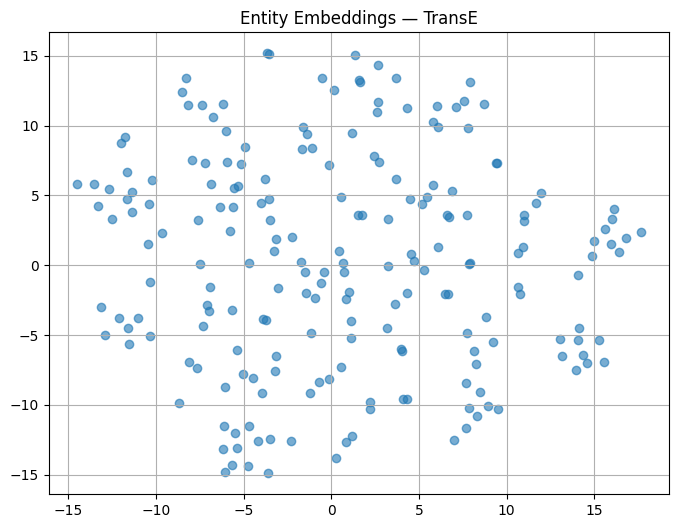

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Accès correct au modèle TransE
model = model_results["RotatE"]["result"].model  # <- la bonne ligne

# Extraction des embeddings
embeddings_transe = model.entity_representations[0]().detach().cpu().numpy()

# Réduction de dimension avec t-SNE
reduced_transe = TSNE(n_components=2, random_state=42).fit_transform(embeddings_transe)

# Affichage du graphe
plt.figure(figsize=(8, 6))
plt.scatter(reduced_transe[:, 0], reduced_transe[:, 1], alpha=0.6)
plt.title("Entity Embeddings — RotatE")
plt.grid(True)
plt.show()


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Accès correct au modèle TransE
model = model_results["TransE"]["result"].model  # <- la bonne ligne

# Extraction des embeddings
embeddings_transe = model.entity_representations[0]().detach().cpu().numpy()

# Réduction de dimension avec t-SNE
reduced_transe = TSNE(n_components=2, random_state=42).fit_transform(embeddings_transe)

# Affichage du graphe
plt.figure(figsize=(8, 6))
plt.scatter(reduced_transe[:, 0], reduced_transe[:, 1], alpha=0.6)
plt.title("Entity Embeddings — TransE")
plt.grid(True)
plt.show()


ValueError: Complex data not supported
[[ 0.42304686-0.5920671j  -1.6153774 +0.2812441j   0.46541896+1.8071135j
  ... -1.6575778 +0.19755676j -0.09239901+1.079247j
   0.31102142-0.539822j  ]
 [ 2.8423007 -2.388127j    0.26689819+0.6929528j  -0.07349462+0.0500029j
  ... -1.2875018 -0.06143591j -0.535237  +0.23292255j
   0.6835749 -0.37317464j]
 [ 0.06837677-1.2175353j   1.9348993 +1.0373638j   1.9172271 +0.913429j
  ...  0.41829148+2.1669295j   1.3658816 -1.5876018j
   1.0856167 -0.2783503j ]
 ...
 [ 0.15198861+0.01087606j -0.11931475+0.1594931j   0.14988413+1.8060216j
  ... -0.65802693+0.51673627j  0.30926955+0.13792837j
   0.8022545 +1.1443865j ]
 [ 0.9876714 +1.0506305j   0.52220356-0.16624801j -0.05501075+0.22776593j
  ...  0.39406368+0.17923695j  0.43722886-0.5934584j
  -0.44031888+1.8269788j ]
 [-0.8972331 -0.19464134j -2.1231577 -0.7207148j  -1.1468089 -1.2249564j
  ... -0.31524062-0.40659133j -1.8121793 +0.8618069j
  -0.30118936-0.1091449j ]]


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Accès correct au modèle TransE
model = model_results["ComplEx"]["result"].model  # <- la bonne ligne

# Extraction des embeddings
embeddings_transe = model.entity_representations[0]().detach().cpu().numpy()

# Réduction de dimension avec t-SNE
reduced_transe = TSNE(n_components=2, random_state=42).fit_transform(embeddings_transe)

# Affichage du graphe
plt.figure(figsize=(8, 6))
plt.scatter(reduced_transe[:, 0], reduced_transe[:, 1], alpha=0.6)
plt.title("Entity Embeddings — ComplEx")
plt.grid(True)
plt.show()


NameError: name 'model_results' is not defined